### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2021 Semester 2

## Assignment 3

**Student Name:**    `Ankita Dhar`

**Student ID:**     `1154197`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Detect lines in the image
Use the Canny edge detector and Hough transform to detect lines in the image.

In [1]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt
import shapely
from shapely.geometry import LineString, Point
import sys
import math
import pandas as pd

In [2]:
#read in an image from a filepath as graycsale.
def findCannyEdge(img) :
    rootpath='./'
    gray = cv2.imread(os.path.join(rootpath, img),cv2.IMREAD_GRAYSCALE)

    gray = cv2.GaussianBlur(gray, (5,5), 0)
    # Canny edge detection with OpenCV
    edge_img = cv2.Canny(gray,100,200,apertureSize=3,L2gradient=True) #two thresholds in Hysteresis Thresholding and Aperture size of the Sobel

    # Set the Figure size of plotting
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,2,1)
    plt.imshow(gray, cmap='gray')  
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(edge_img, cmap='gray')  
    plt.title('Canny edge map')
    plt.axis('off')

    plt.show() 
    
    #Implement Hough transform to detect lines in a Canny edge map 

    # Finds lines in a binary image using the standard Hough transform
    lines = cv2.HoughLines(edge_img, 1, np.pi/180, 100) 
#     , min_theta=np.pi/60, max_theta=np.pi-np.pi/120
    # This function outputs vector of detected lines.
    return lines, gray

In [3]:
#Implement Hough transform to detect lines in a Canny edge map 

# Finds lines in a binary image using the standard Hough transform
# lines = cv2.HoughLines(edge_img, 1, np.pi/90, 200)
# This function outputs vector of detected lines. 
# Each line is represented by a vector (ρ,θ). 
# Whereas ρ/rho is the distance from the coordinate origin (0,0) 
# and θ/theta is the line rotation angle in radians ( 0∼vertical line,π/2∼horizontal line ).

In [4]:
abs(1.6057029-np.pi/90)

1.5707963149601134

In [5]:
np.pi/9

0.3490658503988659

In [6]:
def plotLinesToVanishingPt(lines, gray):
    # (Optional) To better distinguish the detected lines from the background, 
    # we will draw the lines in colour. 
    # Therefore, we first convert the grayscale map to RGB format.
    color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 
    
    edges = []

    # Display by drawing the lines
    for line in lines:
        rho,theta = line[0]
#         print (theta)

        if abs(theta-np.pi/90) < np.pi/9:
            continue
            
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho

        x1, y1 = int(x0 + 1000*(-b)),int(y0 + 1000*(a))
        x2, y2 = int(x0 - 1000*(-b)),int(y0 - 1000*(a))
                
        if abs(y2-y1) < 500 or abs(x2-x1) < 500: continue
            
        edges.append([(x1,y1),(x2,y2)])

        cv2.line(color_img,(x1,y1),(x2,y2),(255,0,0),2)

    plt.imshow(color_img) 
    plt.title("Detected Lines (in red)")
    plt.axis('off')

    plt.show()
    return edges

### 2. Locate the vanishing point
Use RANSAC to locate the vanishing point from the detected lines.

#### 2.1 RANSAC functions
Define two fuctions required by RANSAC: a function to find the point where lines intersect, and a function to compute the distance from a point to a line.

In [7]:
# Find the intersection point
def find_intersection_point(line1, line2):
    
    line1 = LineString([line1[0], line1[1]])
    line2 = LineString([line2[0], line2[1]])

    int_pt = line1.intersection(line2)
    
    if str(int_pt)=="LINESTRING EMPTY": return (None, None)
    
    return (int_pt.x, int_pt.y)
    
# Find the distance from a point to a line
# def find_dist_to_line():
def find_dist_to_line(m, c, x0, y0):
    """ find an intercept point of the line model with
        a normal from point (x0,y0) to it, return
        distance between point (x0, y0) and intercept
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """
 
    # intersection point with the model
    x = (x0 + m*y0 - m*c)/(1 + m**2)
    y = (m*x0 + (m**2)*y0 - (m**2)*c)/(1 + m**2) + c
    dist = math.sqrt((x - x0)**2 + (y - y0)**2)
 
    return dist


#### 2.2 RANSAC loop
Define the main RANSAC loop

In [8]:
def find_line_model(ptA, ptB):
    """ find a line model for the given points
    :param points selected points for model fitting
    :return line model
    """
 
    # [WARNING] vertical and horizontal lines should be treated differently
    #           here we just add some noise to avoid division by zero
 
    # find a line model for these points
    m = (ptB[1] - ptA[1]) / (ptB[0] - ptA[0] + sys.float_info.epsilon)  # slope (gradient) of the line
    c = ptB[1] - m * ptB[0]                                     # y-intercept of the line
 
    return m, c

In [9]:
def ransac_plot(gray, model_lines):
    color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 
    
    edges = []

    # Display by drawing the lines
    for line in model_lines:
        
        cv2.line(color_img,line[0],line[1],(255,0,0),2)

    plt.imshow(color_img) 
    plt.title("Detected Lines (in red)")
    plt.axis('off')

    plt.show()
    return edges

In [10]:
def isFar(x0, y0, pts, ransac_threshold):
    for pt in pts:
        x = pt[0]
        y = pt[1]
        dist = math.sqrt((x - x0)**2 + (y - y0)**2)
        if dist < 3: return False
        
    return True
        

In [11]:
def ransacLoop(edges, gray):

    ransac_ratio = 0.6
    n_samples = 4
    w = 0.5
    ransac_iterations = np.log(1-ransac_ratio)/np.log(1-(w**n_samples))
    ransac_threshold = 3
    print(ransac_iterations)
    # v_pts = []

    ratio = 0.
    model_vanishing_pt = None

    # perform RANSAC iterations
    for it in range(int(ransac_iterations)):

        # randomly sample N points
        n = 2

        np.random.shuffle(edges)

        sample_edges = edges[:n]
        test_edges = edges[n:]

    #     sample_edges = edges[indices_1,:]
    #     test_edges = edges[indices_2,:]

        # fit a line model to the sampled points
        ints_x, ints_y = find_intersection_point(sample_edges[0], sample_edges[1])

        if not ints_x: continue

        model_lines = sample_edges
        num = 0
        
        if not model_vanishing_pt: model_vanishing_pt = (ints_x, ints_y)

        # count the number of inliers num
        # inliers are points whose distance to the line is less than ransac_threshold
        for edge in test_edges:

            m, c = find_line_model(edge[0], edge[1])
            dist = find_dist_to_line(m, c, ints_x, ints_y)

            # check whether it's an inlier or not
            if dist < ransac_threshold:
                model_lines.append(edge)
                num += 1

        # if this value of num is higher than previously saved value,
        # save it, and save the current model parameters
        if num/float(n_samples) > ratio:
            ratio = num/float(n_samples)
            model_vanishing_pt = (ints_x, ints_y)

        # plot the current step with inliers and sample points
    #     ransac_plot(gray, model_lines)
        # plot the current step without showing inliers or sample points
        #ransac_plot(0, x_noise, y_noise, model_m, model_c)

        # we are done in case we have enough inliers
        if num > n_samples*ransac_ratio:
            print('The model is found !')
            break

    # plot the final model
    ransac_plot(gray, model_lines)

    print('\nFinal model:\n')
    print('  ratio = ', ratio)
    print('  model vanishing point = ', model_vanishing_pt)
    
    return model_vanishing_pt
    
#     error=((v_x-model_vanishing_pt[0])**2 +(v_y-model_vanishing_pt[1])**2)**0.5
#     print("error: "+str(error))

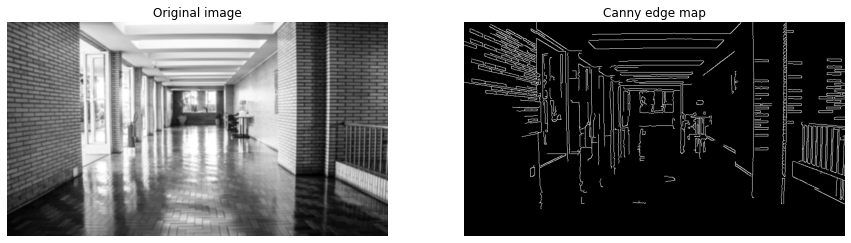

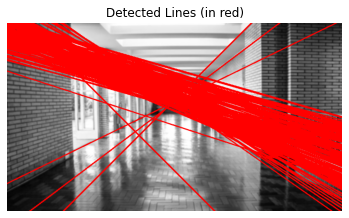

14.197578682055285
The model is found !


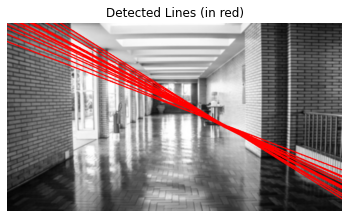


Final model:

  ratio =  2.5
  model vanishing point =  (517.0939578119414, 245.01809081158385)
error: 195.10379479334324


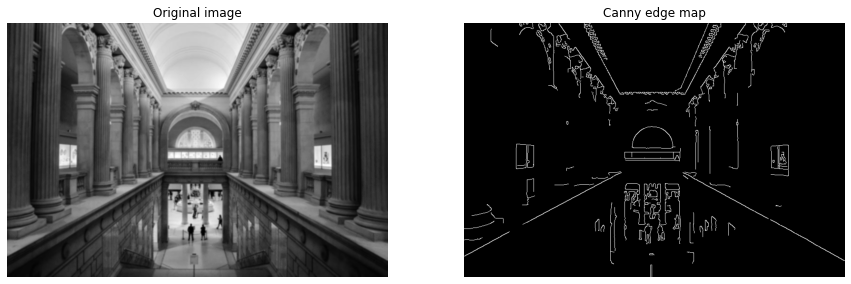

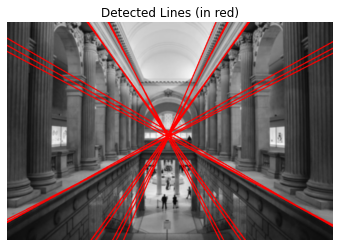

14.197578682055285
The model is found !


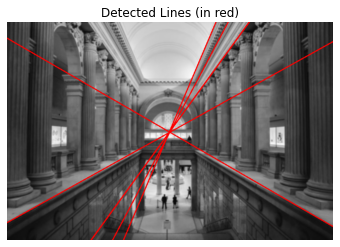


Final model:

  ratio =  0.75
  model vanishing point =  (397.94473876401236, 268.8359087905591)
error: 127.17896092508094


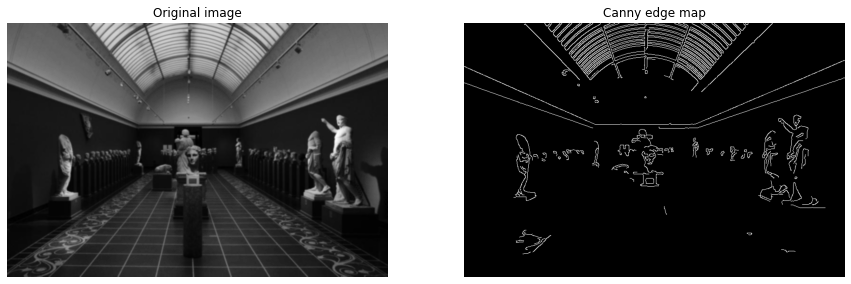

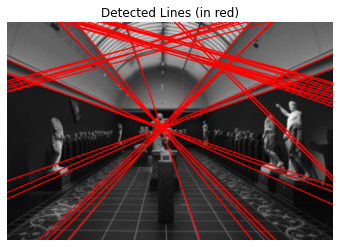

14.197578682055285
The model is found !


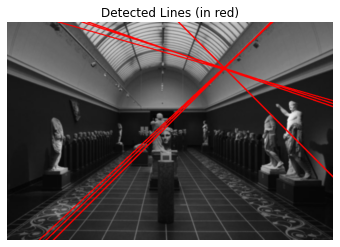


Final model:

  ratio =  1.25
  model vanishing point =  (532.3636363636364, 114.63636363636363)
error: 305.2679760310319


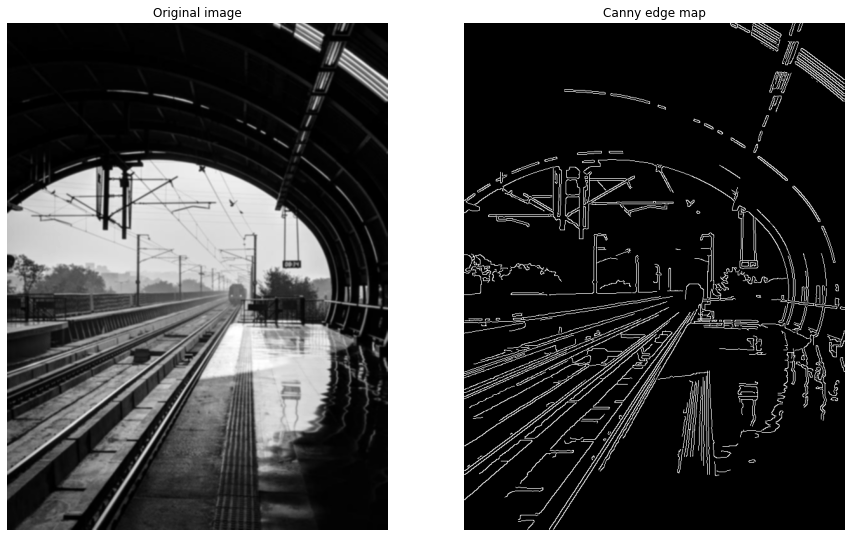

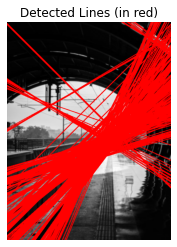

14.197578682055285
The model is found !


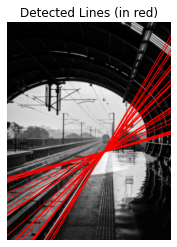


Final model:

  ratio =  5.0
  model vanishing point =  (354.4497411684396, 475.14346663632745)
error: 99.22843032894967


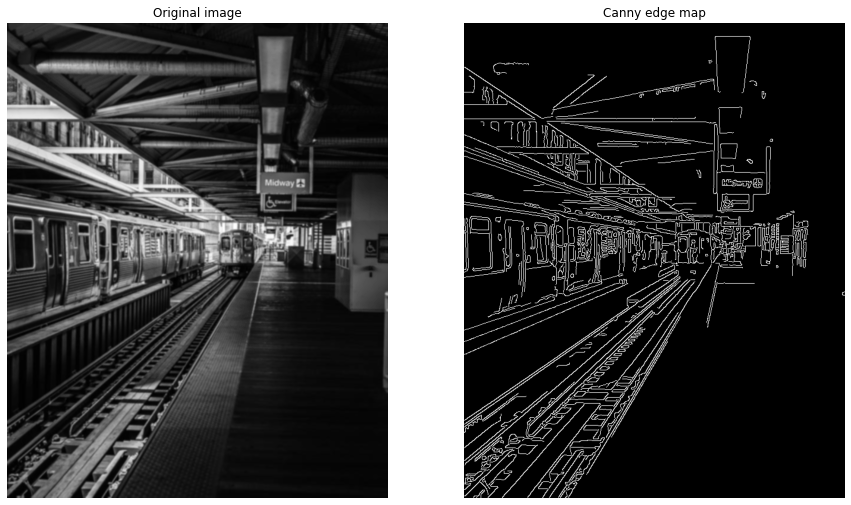

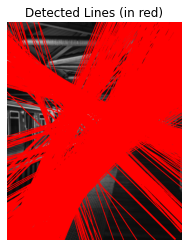

14.197578682055285
The model is found !


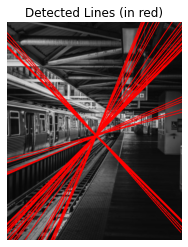


Final model:

  ratio =  7.25
  model vanishing point =  (325.6428857715431, 416.6428857715431)
error: 114.36890943745975


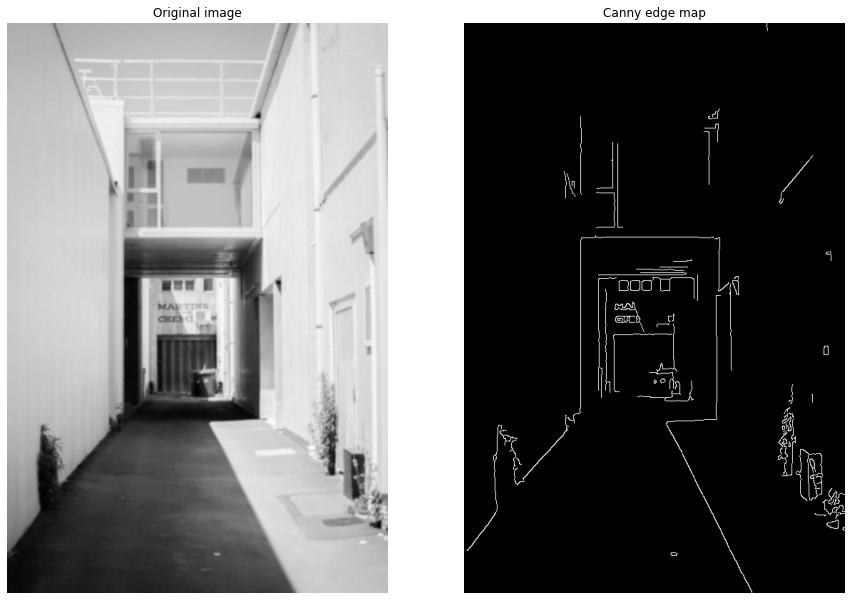

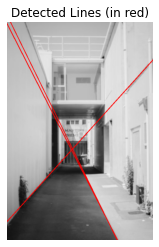

14.197578682055285


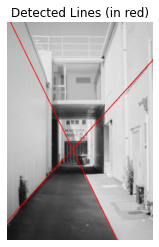


Final model:

  ratio =  0.0
  model vanishing point =  (368.4400139502441, 729.8838642176238)
error: 506.44154411376064


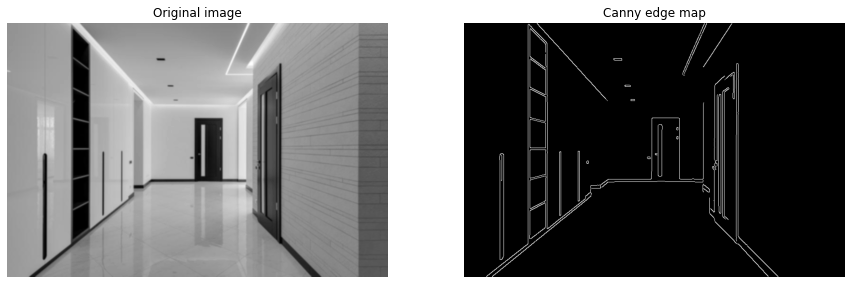

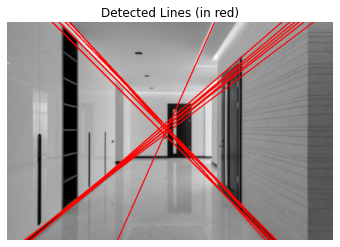

14.197578682055285
The model is found !


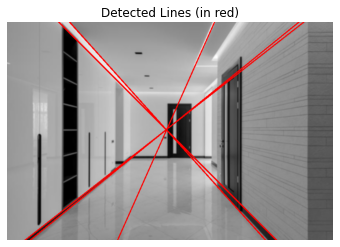


Final model:

  ratio =  0.75
  model vanishing point =  (390.32620320855614, 263.32620320855614)
error: 126.67421680078897


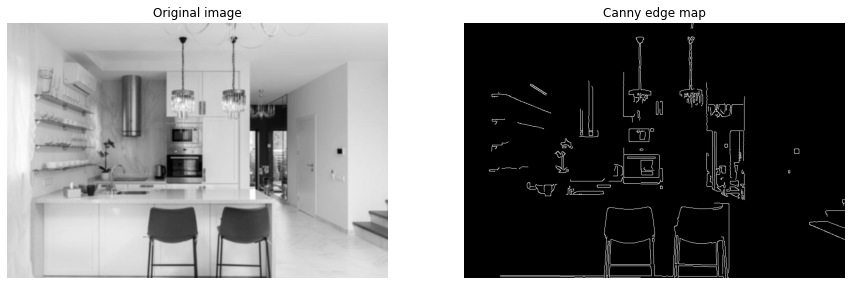

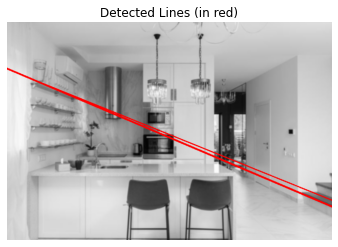

14.197578682055285


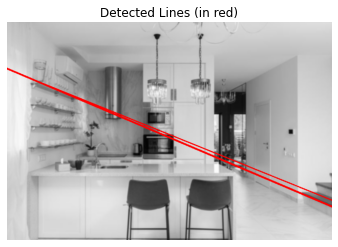


Final model:

  ratio =  0.25
  model vanishing point =  (11.20532001004829, 119.65888854774332)
error: 444.4610808458544


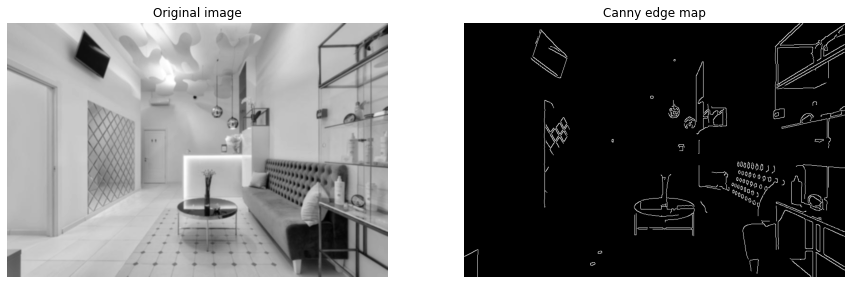

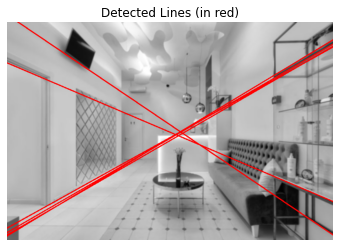

14.197578682055285


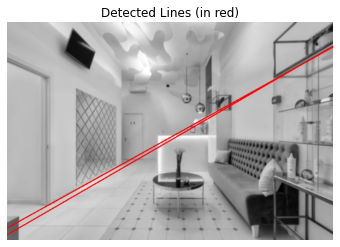


Final model:

  ratio =  0.5
  model vanishing point =  (425.2164189863887, 268.41263730102366)
error: 147.87485251851263


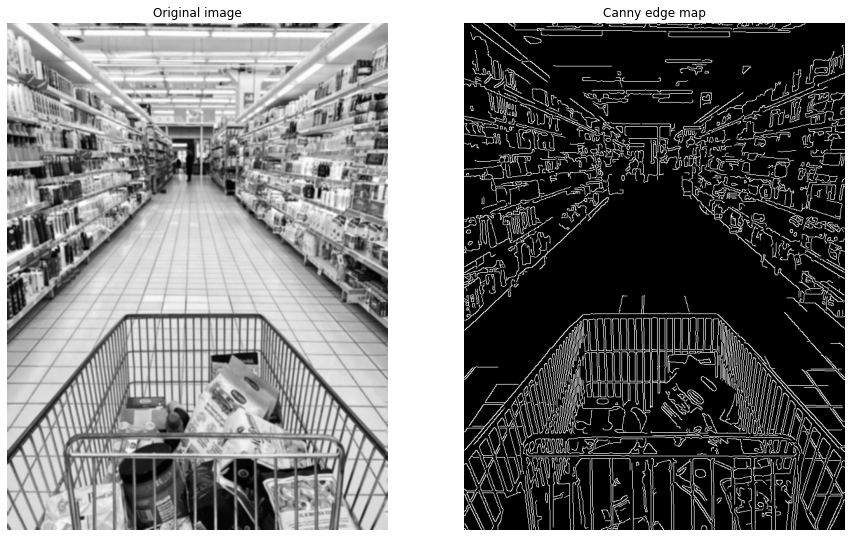

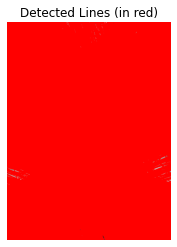

14.197578682055285
The model is found !


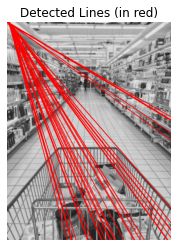


Final model:

  ratio =  7.25
  model vanishing point =  (8.297039941291484, 5.69083603183808)
error: 403.0636511994365


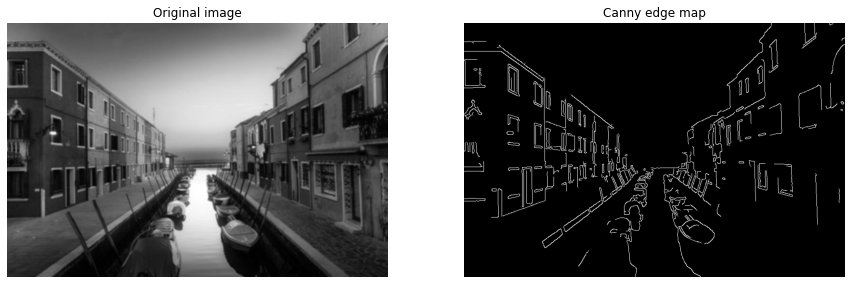

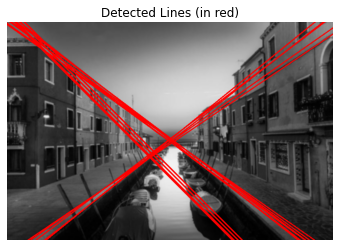

14.197578682055285


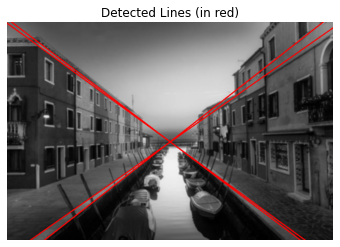


Final model:

  ratio =  0.5
  model vanishing point =  (50.05882352941177, 31.058823529411768)
error: 516.9864668638969


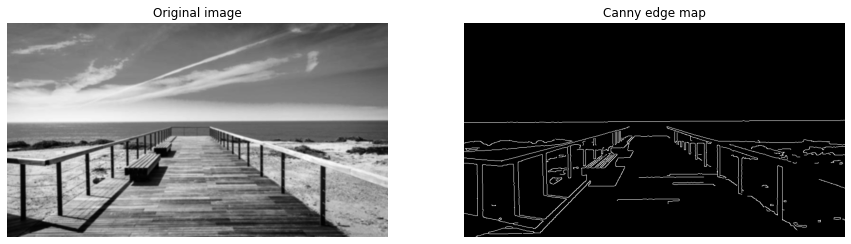

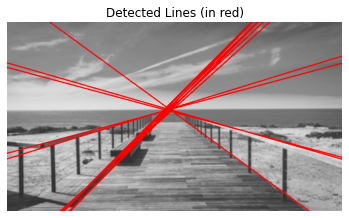

14.197578682055285
The model is found !


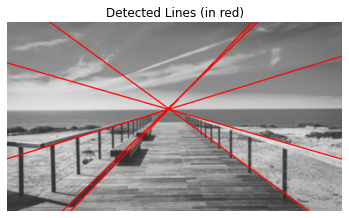


Final model:

  ratio =  0.75
  model vanishing point =  (384.60983092302365, 205.182159143199)
error: 183.8702591551463
mse: 264.21001191777185


In [12]:
imgList = [1,3,6,7,9,10,13,14,15,18,20,21]
data= pd.read_csv("vanishing_points.csv")
v_pts = []
mse = 0
for i in range(len(imgList)):
    lines, gray = findCannyEdge('img'+str(imgList[i])+'.jpg')
    edges = plotLinesToVanishingPt(lines, gray)
    v_pt = ransacLoop(edges, gray) #, data["x"][i], data["y"][i]
    
    if v_pt != None:
        error=((data["x"][i]-v_pt[0])**2 +(data["x"][i]-v_pt[1])**2)**0.5
        mse += error
        print("error: "+str(error))
        
print("mse: "+str(mse/12))

### 3. Main function and evaluation
Run your vanishing point detection method on a folder of images, return the (x,y) locations of the vanishing points, and evaluate the result.

In [13]:
def ld_img_fr_folder(folder):
    file_Names=[]
    images = []
    for filename in os.listdir(folder):
        file_Names.append(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images ,file_Names

In [14]:
# images,file_Names=ld_img_fr_folder('./COMP90086_asst3_2021_images')
# images_len=len(file_Names)


In [15]:
data

image    x    y
0    img1.jpg  404  183
1    img3.jpg  396  276
2    img6.jpg  378  258
3    img7.jpg  379  423
4    img9.jpg  438  367
5   img10.jpg  240  466
6   img13.jpg  390  260
7   img14.jpg  375  270
8   img15.jpg  416  270
9   img18.jpg  292  213
10  img20.jpg  406  288
11  img21.jpg  389  208